# Pacotes

In [22]:
%config InlineBackend.figure_format = 'retina'

# Pacotes gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes estatísticos
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import kpss, grangercausalitytests, q_stat, coint, zivot_andrews, arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Dados

In [3]:
df = pd.read_csv(
    '../data/raw_data.csv',
    index_col=[0], 
    parse_dates=True
)
df = df[[
    "ICMS Nominal milhões de reais", 
    "Índice da Produção Física Industrial com ajuste sazonal (Média 2012 = 100)",
    "Taxa de câmbio",
    "Exportações FOB",
    "Importações FOB"
]]
df.columns = ["ICMS", "Industrial", "Cambio", "Exportacoes", "Importacoes"]
df = df[["Exportacoes", "Cambio", "Importacoes", "Industrial", "ICMS"]] ## Ordenação de Cholesky
df = df.apply(pd.to_numeric, errors='coerce')
df = df[["ICMS"]]
df

,ICMS
2002-01-31,2956.253605
2002-02-28,2612.977840
2002-03-31,2603.100729
2002-04-30,2964.822876
2002-05-31,2848.263981
...,...
2019-11-30,12733.549560
2019-12-31,14602.358693
2020-01-31,13082.640610
2020-02-29,11927.616739


# Modelo

## Seleção da ordem

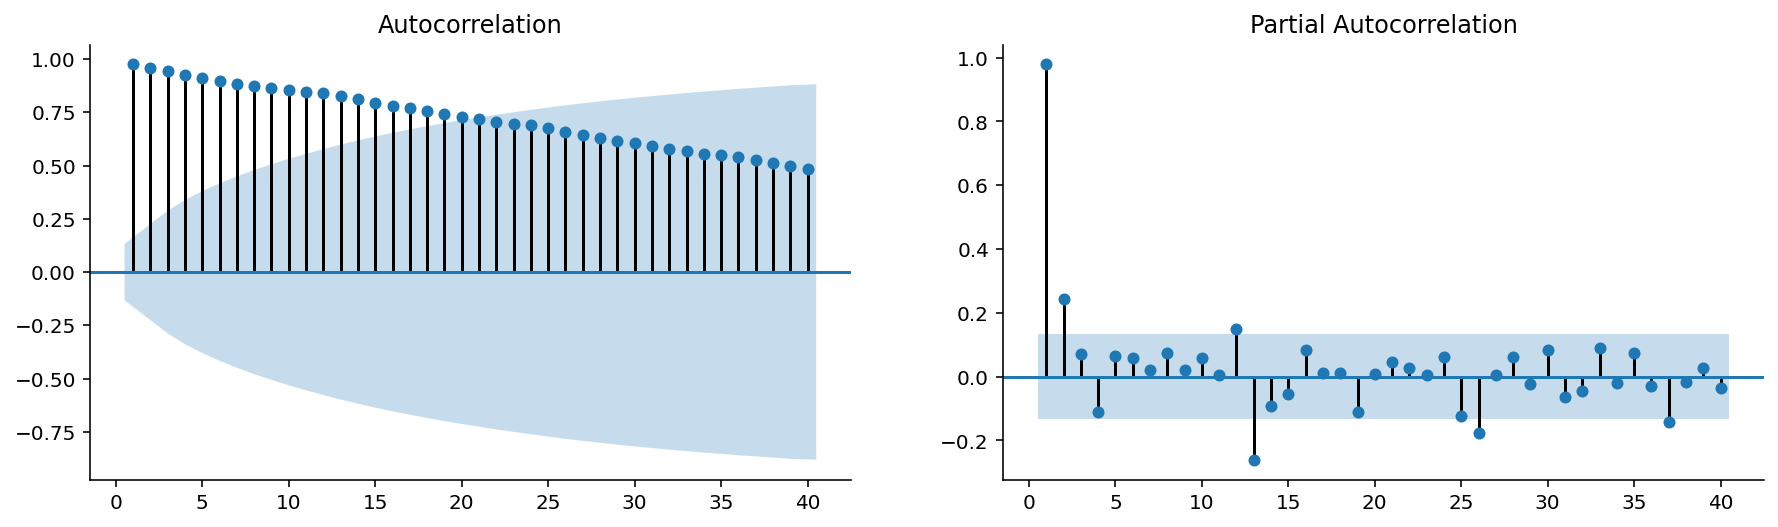

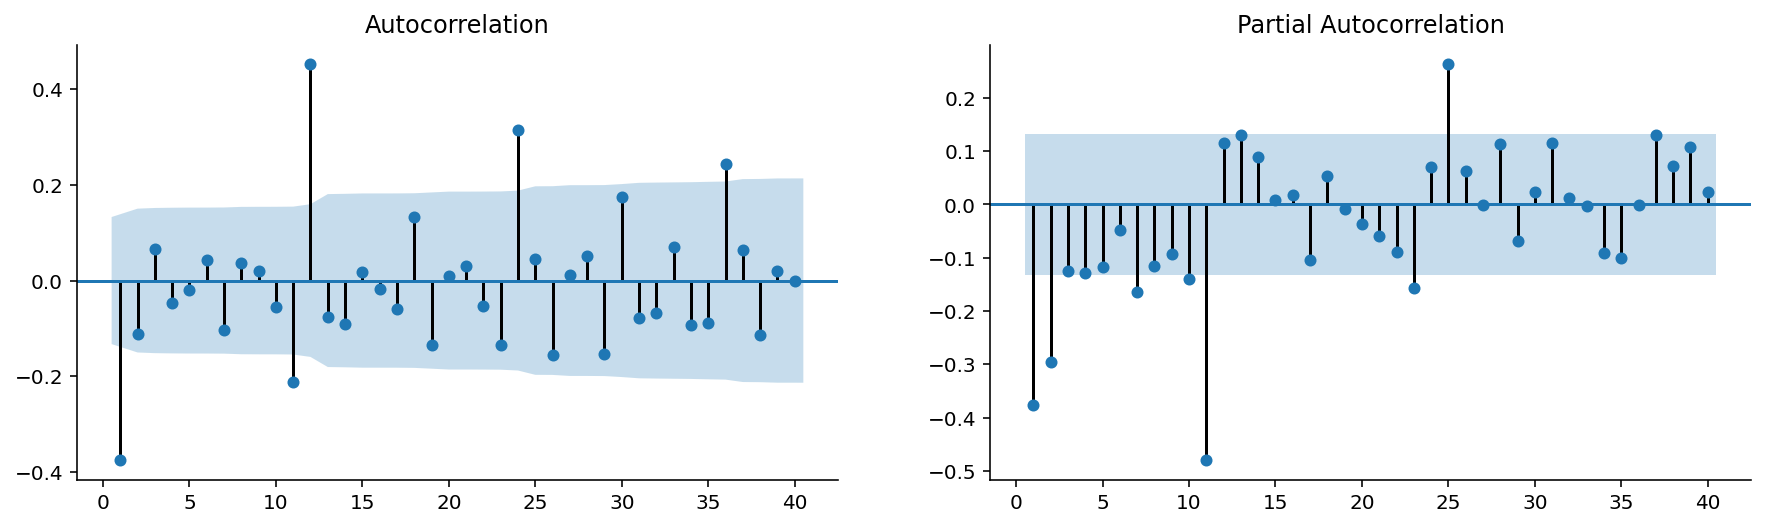

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df, lags=40, ax=axes[0], zero=False)
fig = plot_pacf(df, lags=40, ax=axes[1], zero=False)
sns.despine()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df.diff().dropna(), lags=40, ax=axes[0], zero=False)
fig = plot_pacf(df.diff().dropna(), lags=40, ax=axes[1], zero=False)
sns.despine()
plt.show()

In [19]:
res = arma_order_select_ic(
    df.diff().dropna(), 
    ic=['aic', 'bic'], 
    trend='c', 
)
print(f'AIC: {res.aic_min_order}')
print(f'BIC: {res.bic_min_order}')

AIC: (1, 1)
BIC: (1, 1)


## Estimação

In [96]:
model = sm.tsa.statespace.SARIMAX(
    df, 
    order=(0,1,1), 
    seasonal_order=(1,1,1,12), 
    simple_differencing=True, 
    freq="M",
)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        D.DS12.ICMS   No. Observations:                  206
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1511.129
Date:                            Sun, 17 May 2020   AIC                           3030.257
Time:                                    12:06:48   BIC                           3043.569
Sample:                                02-28-2003   HQIC                          3035.641
                                     - 03-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7088      0.050    -14.303      0.000      -0.806      -0.612
ar.S.L12       0.1323      0.112      1.176      0.240      -0.088       0.353
ma.S.L12      -0.7977      0.093     -8.550      0.000      -0.981      -0.615
sigma2       1.31e+05   7883.278     16.616      0.000    1.16e+05    1.46e+05
===================================================================================
Ljung-Box (Q):                       30.94   Jarque-Bera (JB):               125.12
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Pós estimação

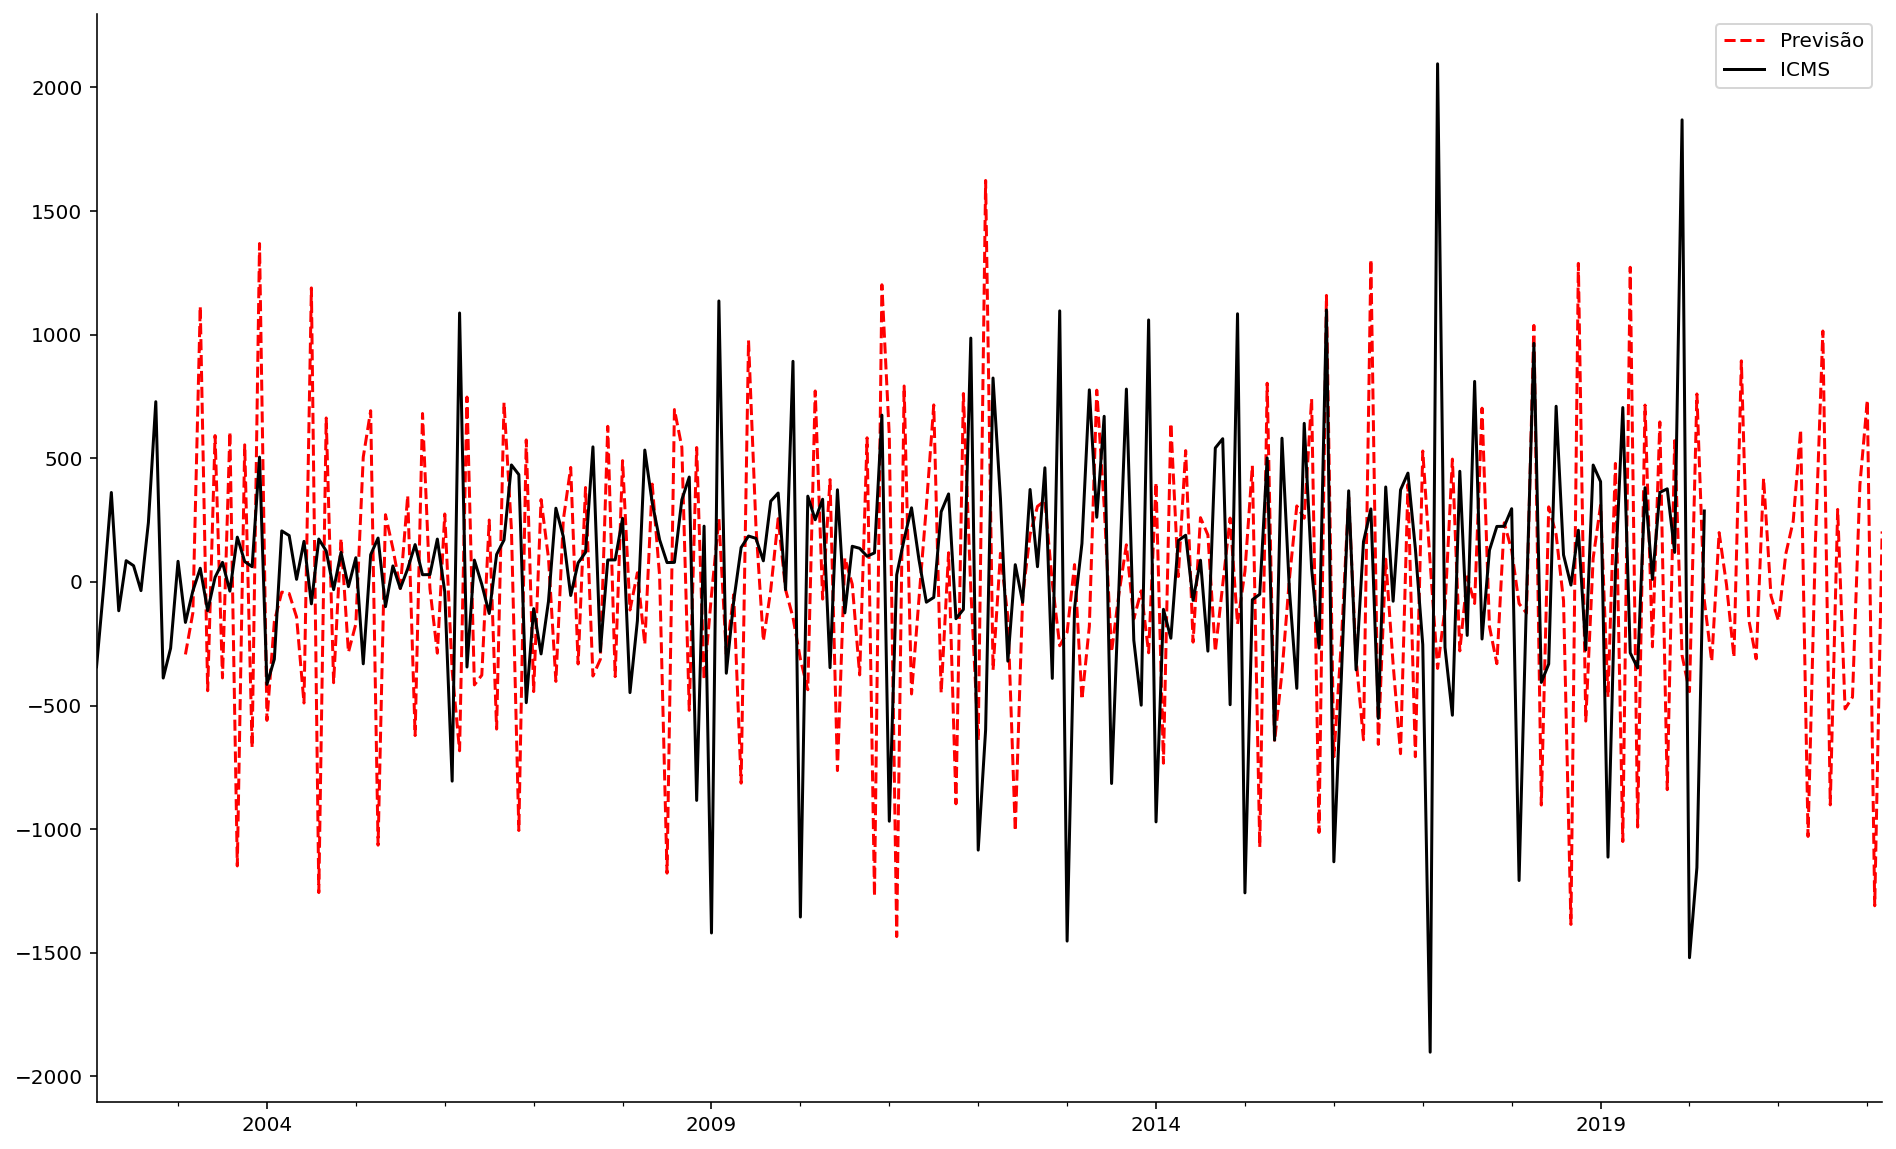

In [97]:
fig, ax = plt.subplots(figsize=(16,10))

res.simulate(len(df)-1+12).plot(ax=ax, color='red', ls='--', label="Previsão")
df.diff().dropna().plot(ax=ax, color='black')
ax.legend()
sns.despine()
plt.show()

## Previsão

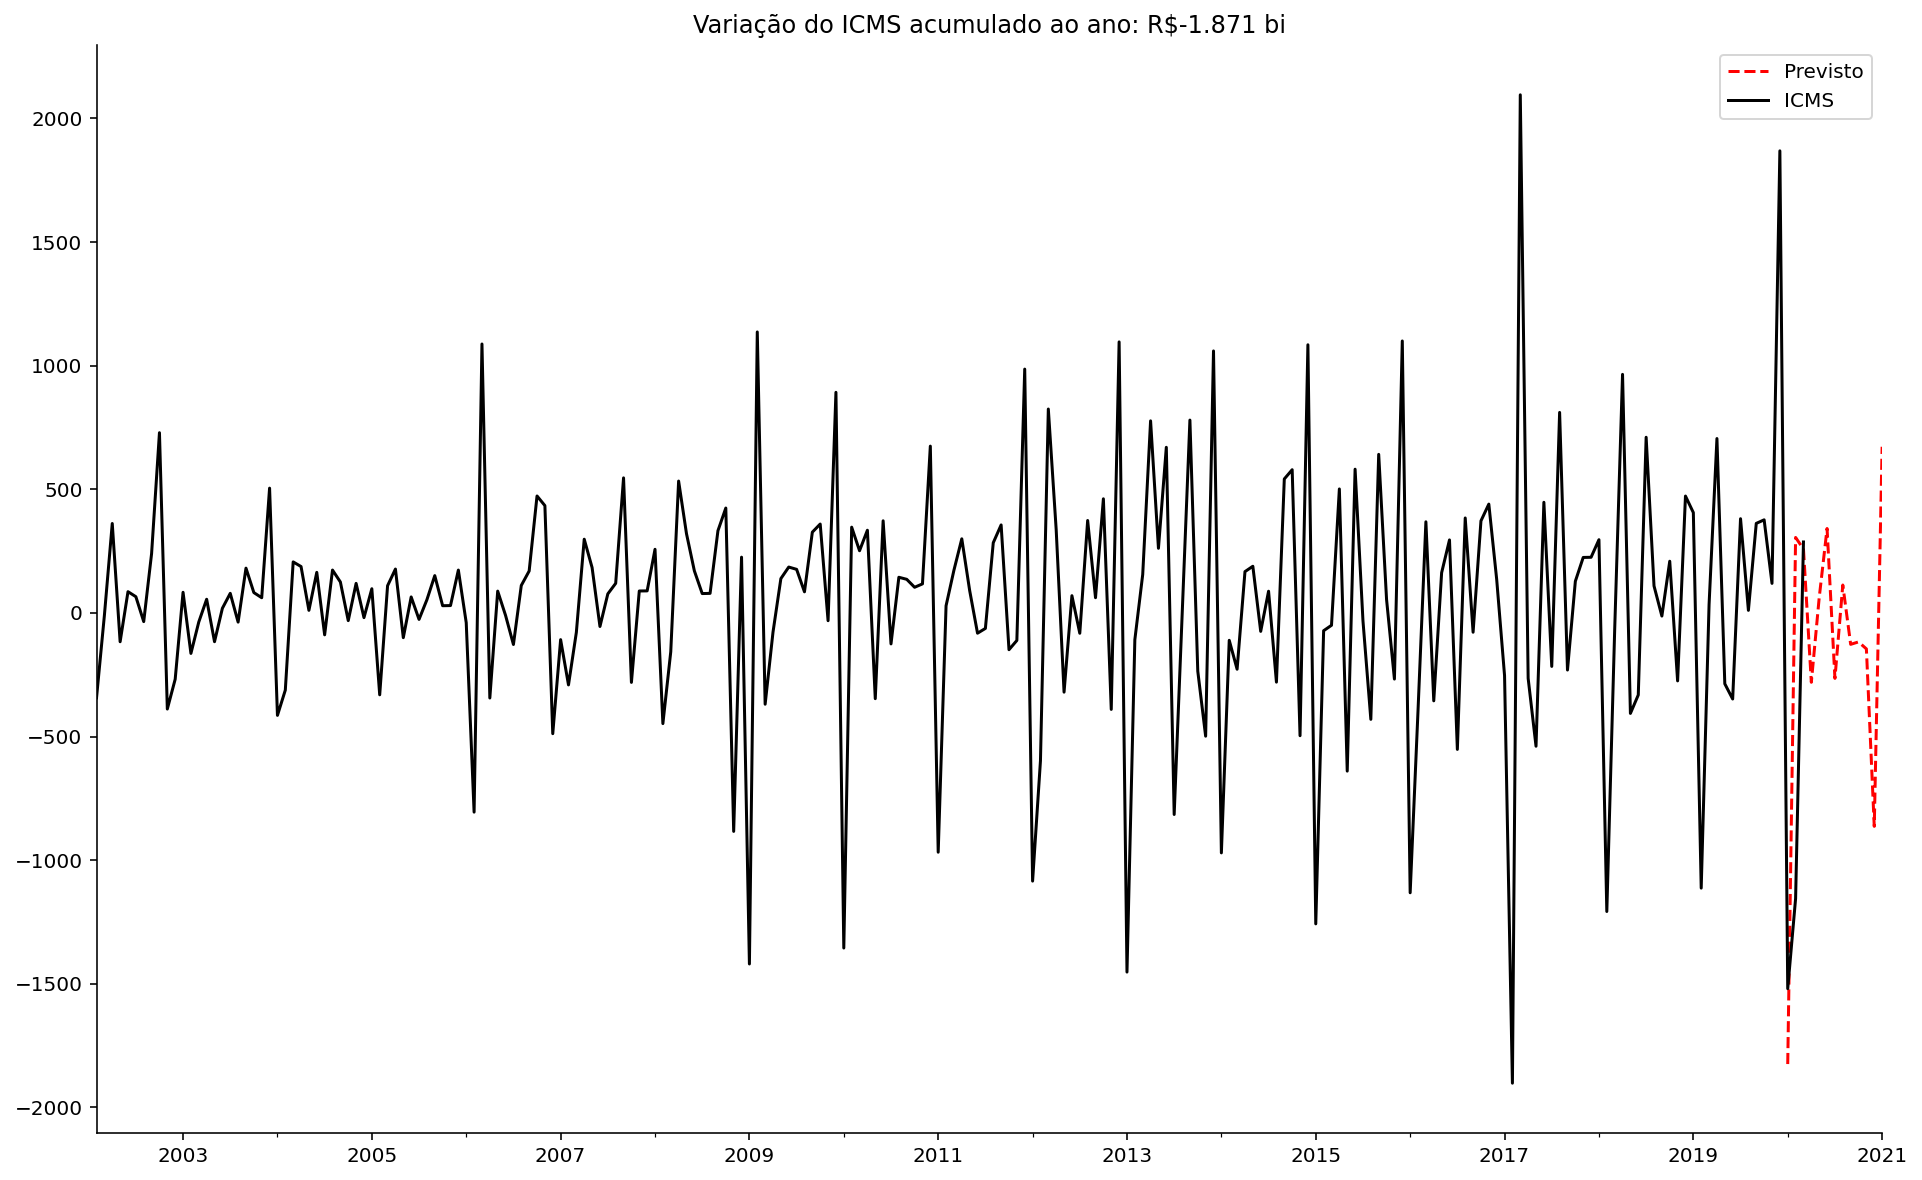

In [100]:
from datetime import datetime as dt

previsao = res.predict(start=dt(2020,1,31), end=dt(2021,1,31), dynamic=True)

fig, ax = plt.subplots(figsize=(16,10))
previsao.plot(ax=ax, label="Previsto", color='red', ls='--')
df.diff().dropna().plot(ax=ax, color='black')
ax.legend()
ax.set_title(f"Variação do ICMS acumulado ao ano: R${previsao.sum()/1000:.3f} bi")
sns.despine()
plt.show()